# Comparison between implementations locally weighted regression LO(W)ESS

In this noteook I investigate how `lowess` from statsmodels (using the wrapper of Allen Downey) or `loess` from skmisc behave

One issue is how to compare consistently these smoothers with data and how to represent a confidence interval.

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import ipywidgets
import tqdm
from astropy.table import Table
import pickle

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
from skmisc.loess import loess

In [4]:
def make_lowess(series, **kwargs):
    """Adapted from here: https://www.allendowney.com/blog/2019/04/01/local-regression-in-python/"""
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog, **kwargs)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [5]:
table_path = "mb.69002_p100_a800_r600_new_adhoc_orbit_sideon_structure.fits"

In [6]:
df = Table.read(table_path).to_pandas()

In [7]:
df.head()

,amplitude,mu_e,r_eff,n,rms_err,exit_mode,numiter
0,23.438982,23.438982,1.741690,0.992784,0.766364,0,101
1,23.353041,23.353041,1.712633,0.939289,0.712010,0,84
2,23.115799,23.115799,1.696579,0.782170,0.762267,0,113
3,23.016631,23.016631,1.693127,0.768203,0.780913,0,108
4,23.141034,23.141034,1.737935,0.763625,0.717844,0,99


In [8]:
df.describe()

,amplitude,mu_e,r_eff,n,rms_err,exit_mode,numiter
count,563.000000,563.000000,563.000000,563.000000,563.000000,563.0,563.000000
mean,25.221631,25.221631,2.758051,0.767692,0.395050,0.0,99.863233
std,1.689513,1.689513,1.125883,0.370533,0.198346,0.0,10.096198
min,21.383525,21.383525,1.206687,0.126834,0.143230,0.0,74.000000
25%,24.045809,24.045809,1.969449,0.491435,0.228060,0.0,93.000000
50%,25.207991,25.207991,2.332029,0.851138,0.369301,0.0,99.000000
75%,26.489874,26.489874,3.442626,1.004310,0.488239,0.0,106.000000
max,28.544686,28.544686,5.467743,2.005144,1.310804,0.0,162.000000


This is the relation I want to smooth

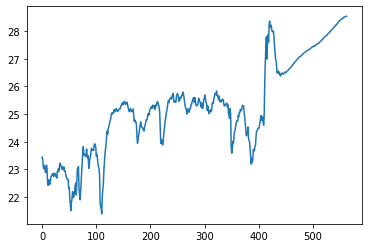

In [9]:
plt.plot(df.index, df.mu_e);

# Let's try the LOESS from `skmisc`

https://has2k1.github.io/scikit-misc/loess.html

In [10]:
x = df.index
y = df.mu_e.values

In [11]:
loess?

Init signature: loess(self, /, *args, **kwargs)
Docstring:     
loess(x, y, weights=None, **options)

Locally-weighted regression

A loess object is initialized with the combined parameters of
:class:`loess_inputs`, :class:`loess_model` and
:class:`loess_control`. The parameters of :class:`loess_inputs`
i.e ``x``, ``y`` and ``weights`` can be positional in that order.
In the descriptions below, `n` is the number of observations,
and `p` is the number of predictor variables.

Parameters
----------
x : ndarray of shape (n, p)
    n independent observations for p no. of variables
y : ndarray of shape (n,)
    A (n,) ndarray of response observations
weights : ndarray of shape (n,) or None
    Weights to be given to individual observations
    in the sum of squared residuals that forms the local fitting
    criterion. If not None, the weights should be non negative. If
    the different observations have non-equal variances, the weights
    should be inversely proportional to the variances.

## Start by initialization and fitting

In [12]:
l = loess(x, y, span=0.1)
l.fit()

In [13]:
print(l.input_summary())

Model parameters
----------------
Family          : gaussian
Span            : 0.1
Degree          : 2
Normalized      : True
Parametric      : [False]
Drop_square     : [False]

Control
-------
Surface type     : interpolate
Statistics       : approximate
Trace estimation : approximate
Cell size        : 0.2
Nb iterations    : 4


In [14]:
print(l.output_summary())

Output Summary
--------------
Number of Observations         : 563
Fit flag                       : 1
Equivalent Number of Parameters: 29.8
Residual Standard Error        : 0.2909


## Then we can predict the local regression

In [15]:
l.predict?

Docstring:
loess.predict(self, newdata, stderror=False)

Compute loess estimates at the given new data points newdata.

Parameters
----------
newdata : ndarray of shape (m, p)
    Independent variables where the surface must be estimated,
    with m the number of new data points, and p the number of
    independent variables.
stderror : boolean
    Whether the standard error should be computed

Returns
-------
A :class:`loess_prediction` object.
Type:      builtin_function_or_method


In [16]:
prediction = l.predict(x, stderror=True)
smoothed = prediction.values

## Confidence interval can be computed

In [17]:
prediction.confidence?

Docstring:
loess_prediction.confidence(self, alpha=0.05)

Returns the pointwise confidence intervals

Parameters
----------
alpha : float
    The alpha level for the confidence interval. The
    default ``alpha=0.05`` returns a 95% confidence
    interval. Therefore it must be in the range (0, 1).

Returns
-------
out : loess_confidence_intervals
    Confidence intervals object. It has attributes `fit`,
    `lower` and `upper`
Type:      builtin_function_or_method


This is the 99.999% confidence interval

In [18]:
alpha_level = 1e-5

In [19]:
conf = prediction.confidence(alpha=alpha_level)

ll = conf.lower
ul = conf.upper

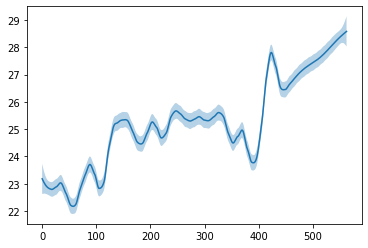

In [20]:
# plt.scatter(x, y, s=1)
plt.plot(x, smoothed)
plt.fill_between(x,ll,ul,alpha=.33);

# LOWESS from `statsmodels`

In [21]:
my_lowess = make_lowess(df.mu_e, frac=0.1)

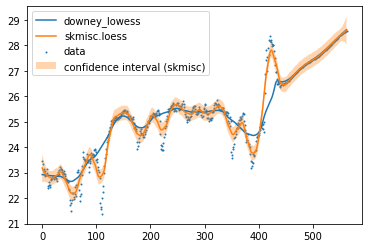

In [22]:
# plt.plot(x, y, label='data')
plt.scatter(x, y, s=1, label='data')
plt.plot(x, my_lowess, label='downey_lowess')
plt.plot(x, smoothed, label='skmisc.loess')
plt.fill_between(x,ll,ul,alpha=.33, label='confidence interval (skmisc)')
plt.legend()

# Rolling mean

In [23]:
window_size = 40
rolling = df.mu_e.rolling(window_size).mean()

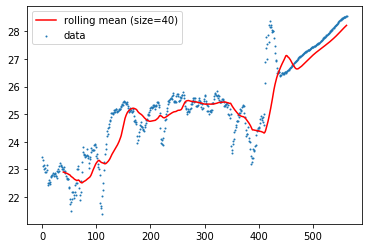

In [24]:
plt.scatter(x, y, s=1, label='data')
plt.plot(x, rolling, label=f'rolling mean (size={window_size})', color='r');
plt.legend();

In [25]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [26]:
lowess?

Signature:
lowess(
    endog,
    exog,
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True,
)
Docstring:
LOWESS (Locally Weighted Scatterplot Smoothing)

A lowess function that outs smoothed estimates of endog
at the given exog values from points (exog, endog)

Parameters
----------
endog: 1-D numpy array
    The y-values of the observed points
exog: 1-D numpy array
    The x-values of the observed points
frac: float
    Between 0 and 1. The fraction of the data used
    when estimating each y-value.
it: int
    The number of residual-based reweightings
    to perform.
delta: float
    Distance within which to use linear-interpolation
    instead of weighted regression.
is_sorted : bool
    If False (default), then the data will be sorted by exog before
    calculating lowess. If True, then it is assumed that the data is
    already sorted by exog.
missing : str
    Available options are 'none', 'drop', and 'raise'. If 